In [6]:
# --- Define Suffixes to Exclude Here ---
exclude_suffixes_list = [
    # "8470",  # Example: exclude sessions ending in 8449
    # "3475",  # Example: exclude sessions ending in 5633
    # "7376",  # Example: exclude sessions ending in 5633
    # "9203",  # Example: exclude sessions ending in 5633
    # "7807",  # Example: exclude sessions ending in 5633
    # "7161",
      
    # "5708",  # Example: exclude sessions ending in 5633
    # "2307",  # Example: exclude sessions ending in 5633
    # "4278",  # Example: exclude sessions ending in 5633
    # "8464",  # Example: exclude sessions ending in 5633
    # "2801",  # Example: exclude sessions ending in 5633
    # "5106",  # Example: exclude sessions ending in 5633
    # "2181",  # Example: exclude sessions ending in 5633
]
# Convert to tuple for use with .endswith()
exclude_suffixes_tuple = tuple(exclude_suffixes_list)
# --- End Define Suffixes ---

In [7]:
# In a cell BEFORE the plotting cell

import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

def extract_trust_trajectory(base_dir, exclude_suffixes=None):
    """Extracts trust score history for trajectory plotting."""
    if exclude_suffixes is None:
        exclude_suffixes = set()
    else:
        exclude_suffixes = set(str(s) for s in exclude_suffixes)

    trajectory_data = []
    base_path = Path(base_dir)
    if not base_path.is_dir():
        print(f"Warning: Trajectory directory not found - {base_dir}")
        return pd.DataFrame()

    folders_found = 0
    folders_excluded = 0
    for item in base_path.iterdir():
        if item.is_dir():
            folders_found += 1
            # --- Exclude based on suffix ---
            should_exclude = False
            for suffix in exclude_suffixes:
                if item.name.endswith(suffix):
                    should_exclude = True
                    break
            if should_exclude:
                folders_excluded += 1
                continue # Skip excluded folder
            # --- End Exclusion Check ---

            conv_path = item / "conversation.json"
            if conv_path.exists():
                try:
                    with open(conv_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                    session_id = data.get("session_id", item.name)
                    has_dt = data.get("has_digital_twin", False) # Get the flag for this session

                    # Extract the list of trust score measurements
                    trust_scores_history = data.get("metrics_history", {}).get("trust_scores", [])

                    for score_entry in trust_scores_history:
                        if isinstance(score_entry, dict) and "score" in score_entry and "message_count" in score_entry:
                             trajectory_data.append({
                                 "session_id": session_id,
                                 "has_digital_twin": has_dt,
                                 "message_count": score_entry["message_count"],
                                 "trust_score": score_entry.get("score") # Use .get for safety
                             })

                except json.JSONDecodeError:
                    print(f"Warning: Could not decode JSON from {conv_path}. Skipping trajectory.")
                except Exception as e:
                    print(f"Warning: Error processing trajectory for {conv_path}: {e}")

    print(f"Trajectory Extraction ({base_dir}): Folders found: {folders_found}, Excluded: {folders_excluded}")
    return pd.DataFrame(trajectory_data)


Extracting trust trajectories...
Trajectory Extraction (../data_output): Folders found: 41, Excluded: 0
Trajectory Extraction (../data_output_wout_twin): Folders found: 38, Excluded: 0
Total trajectory points loaded: 423
Value counts for has_digital_twin:
has_digital_twin
True     231
False    192
Name: count, dtype: int64


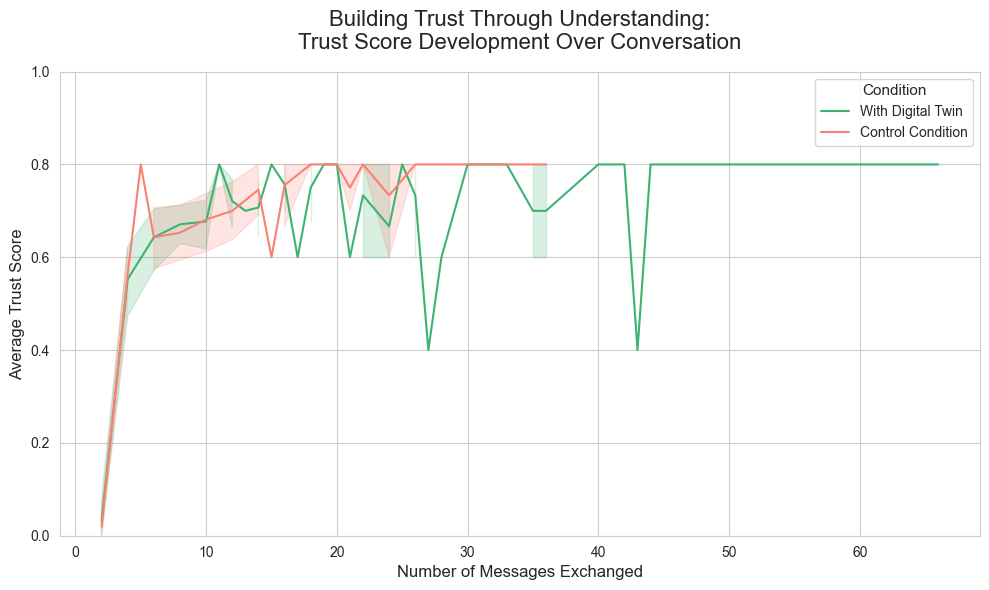

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import numpy as np


# --- Extract Trajectory Data ---
print("Extracting trust trajectories...")
df_traj_with_dt = extract_trust_trajectory("../data_output", exclude_suffixes=exclude_suffixes_list)
df_traj_without_dt = extract_trust_trajectory("../data_output_wout_twin", exclude_suffixes=exclude_suffixes_list)

# Combine the trajectory data
if not df_traj_with_dt.empty or not df_traj_without_dt.empty:
    trajectory_df = pd.concat([df_traj_with_dt, df_traj_without_dt], ignore_index=True)

    # Ensure correct data types
    trajectory_df['message_count'] = pd.to_numeric(trajectory_df['message_count'], errors='coerce')
    trajectory_df['trust_score'] = pd.to_numeric(trajectory_df['trust_score'], errors='coerce')
    trajectory_df = trajectory_df.dropna(subset=['message_count', 'trust_score']) # Drop rows where conversion failed

    print(f"Total trajectory points loaded: {len(trajectory_df)}")
    print(f"Value counts for has_digital_twin:\n{trajectory_df['has_digital_twin'].value_counts()}")

else:
    trajectory_df = pd.DataFrame() # Create empty df if no data


# --- Plotting ---
if not trajectory_df.empty:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6)) # Single plot figure

    # Use lineplot - it aggregates automatically (shows mean trend + confidence interval)
    lineplot = sns.lineplot(
        data=trajectory_df,
        x='message_count',
        y='trust_score',
        hue='has_digital_twin', # Color lines based on condition
        palette=['mediumseagreen', 'salmon'], # Colors for True (With DT), False (Control)
        hue_order=[True, False], # Ensure consistent color mapping
        errorbar=('ci', 95) # Show 95% confidence interval; use None to hide
        # estimator=np.median # Uncomment to plot median instead of mean
    )

    # --- Customize Appearance ---
    plt.title('Building Trust Through Understanding:\nTrust Score Development Over Conversation', fontsize=16, y=1.03)
    plt.xlabel('Number of Messages Exchanged', fontsize=12)
    plt.ylabel('Average Trust Score', fontsize=12)
    plt.ylim(0, 1) # Trust scores are typically 0-1

    # Customize Legend
    handles, labels = lineplot.get_legend_handles_labels()
    # Map True/False labels to desired text
    new_labels = ['With Digital Twin' if label == 'True' else 'Control Condition' for label in labels]
    plt.legend(handles=handles, labels=new_labels, title='Condition', title_fontsize='11')

    plt.tight_layout()
    plt.show()

else:
    print("\nNo trajectory data available to plot.")
